In [1]:
import pandas as pd

original_df = pd.read_csv('dataset_processed.csv')
original_df[original_df.synonym.isna()].count()

Unnamed: 0.1         145
Unnamed: 0           145
characteristic_id    145
characteristic       145
language_en          145
guess_id             145
percentile           145
guessed_label_id     145
layer                145
cluster              145
cluster_id           145
image                145
label_en             145
characteristic_en    145
synonym                0
dtype: int64

In [2]:
import pandas as pd
import numpy as np
from explainations_utils import *

import warnings
warnings.filterwarnings('ignore')

# CONSTANTS FILES AND FOLDERS
ORIGINAL_DATASET_FILE_NAME = 'dataset_processed.csv'
HEATMAP_DATASET_FILE_NAME = 'heatmaps.csv'
RESIGNS_DATASET_FILE_NAME = 'db_for_data_analysis_only_resigns.csv'
UNLABELED_DATASET_FILE_NAME = 'additional_games.csv'
WEIGHTS_FILE_NAME = 'weights.npy'
IMAGE_FOLDER = 'images/'

# LABEL TO BE STUDIED
LABELS = ['Cassette Player', 'Chainsaw', 'Church', 'Dog', 'French Horn', 'Garbage Truck', 'Gas Pump', 'Golf Ball', 'Parachute', 'Fish']
LABELS_ID = [1,2,3,4,5,6,7,8,9,10]

# ENABLE TRANSLATOR
BOOL_TRANSLATE = False

#Read original datasets
original_df = pd.read_csv(ORIGINAL_DATASET_FILE_NAME)
df = original_df[~original_df.synonym.isna()]
heatmap_df = pd.read_csv(HEATMAP_DATASET_FILE_NAME)
resigns_df = pd.read_csv(RESIGNS_DATASET_FILE_NAME)
weights_list = np.load(WEIGHTS_FILE_NAME, allow_pickle=True)
unlabeled_df = pd.read_csv(UNLABELED_DATASET_FILE_NAME)
#to_translate = input('Do you want to translate? (y/n)')

def generate(df, LABEL_STRING, LABEL_ID):

    df = df[df.label_en == LABEL_STRING]

    #Compute scores for each characteristic and split dataset into cluster info and characteristics
    df_char, df_cluster = split_dataset_for_cluster_and_features(df, original_df, resigns_df, unlabeled_df, weights_list, LABEL_STRING, LABEL_ID)

    #Get best characteristics for each cluster
    df_cluster = compute_best_characteristics(df_char, df_cluster)

    #Merging clusters that are mostly seeing the same thing
    df_cluster_merged = merge_clusters_on_best_characteristics(df_cluster)

    df_cluster_fullmerge = merge_all_clusters(df_cluster)

    return df_cluster_merged, df_char, df_cluster, df_cluster_fullmerge

In [3]:
df_merged, df_char, df_cluster = [], [], []
for i in range(0, 10):
    merged, char, cluster, df_cluster_fullmerge = generate(df, LABELS[i], LABELS_ID[i])
    df_merged.append(merged)
    df_char.append(char)
    df_cluster.append(cluster)

In [4]:
from matplotlib import pyplot as plt

def regression_line(x, y):
    n = len(x)
    xy = np.multiply(x,y)
    x2 = np.power(x, 2)
    numerator = n*sum(xy) - sum(x)*sum(y)
    denominator = n*sum(x2) - sum(x)**2
    coef = numerator/denominator
    intercept = (sum(y)-coef*sum(x))/n
    return coef, intercept


def make_label_plot(df_char, df_cluster):
    score_dict = {}
    for char in df_char['characteristic'].drop_duplicates().to_list():
        tot_score = np.round(sum(df_char[df_char.characteristic == char]['score'].to_list()), 5)
        score_dict.update({char:tot_score})
    score_dict = sorted(score_dict.items(), key=lambda x:x[1], reverse=True)
    labels = dict(score_dict).keys()

    m_dict = {}
    x = np.linspace(5, 13, 9)
    for label in labels:
        label_y = []
        w_counter = 0
        for i in range(0, 9):
            layer_score = np.mean(df_char[df_char.characteristic == label][df_char.cluster_id.isin(df_cluster[df_cluster.layer == i]['cluster_id'])]['score'].to_list())
            layer_weight = np.mean(df_cluster[df_cluster.layer == i][df_cluster.cluster_id.isin(df_char[df_char.characteristic == label]['cluster_id'])]['weight'].to_list())
            if np.isnan(layer_score): layer_score = 0
            if np.isnan(layer_weight): layer_weight = 0
            #print('  Layer', str(i)+':', layer_weight)
            w_counter += layer_score
            label_y.append(layer_score)
        coef, intercept = regression_line(x, label_y)
        m_dict.update({label:coef})
    labels2 = dict(sorted(m_dict.items(), key=lambda x:x[1], reverse=True)[0:6]).keys()

    plt.figure(figsize=(16, 8))
    for label in labels2:
        label_y = []
        w_counter = 0
        for i in range(0, 9):
            layer_score = np.mean(df_char[df_char.characteristic == label][df_char.cluster_id.isin(df_cluster[df_cluster.layer == i]['cluster_id'])]['score'].to_list())
            layer_weight = np.mean(df_cluster[df_cluster.layer == i][df_cluster.cluster_id.isin(df_char[df_char.characteristic == label]['cluster_id'])]['weight'].to_list())
            if np.isnan(layer_score): layer_score = 0
            if np.isnan(layer_weight): layer_weight = 0
            #print('  Layer', str(i)+':', layer_weight)
            w_counter += layer_score
            label_y.append(layer_score)
        coef, intercept = regression_line(x, label_y)
        #plt.plot([0,8], [intercept, intercept+coef*8], label = label)
        plt.plot(x, label_y, label = label)
    plt.legend()
    plt.xlim(left = 4.5, right = 14)
    plt.xticks(x)
    plt.show()

    m_dict = sorted(m_dict.items(), key=lambda x:x[1])
    labels3 = dict(m_dict[0:6]).keys()

    plt.figure(figsize=(16, 8))
    for label in labels3:
        label_y = []
        w_counter = 0
        for i in range(0, 9):
            layer_score = np.mean(df_char[df_char.characteristic == label][df_char.cluster_id.isin(df_cluster[df_cluster.layer == i]['cluster_id'])]['score'].to_list())
            layer_weight = np.mean(df_cluster[df_cluster.layer == i][df_cluster.cluster_id.isin(df_char[df_char.characteristic == label]['cluster_id'])]['weight'].to_list())
            if np.isnan(layer_score): layer_score = 0
            if np.isnan(layer_weight): layer_weight = 0
            #print('  Layer', str(i)+':', layer_weight)
            w_counter += layer_score
            label_y.append(layer_score)
        coef, intercept = regression_line(x, label_y)
        #plt.plot([0,8], [intercept, intercept+coef*8], label = label)
        plt.plot(x, label_y, label = label)
    plt.legend()
    plt.xlim(left = 4.5, right = 14)
    plt.xticks(x)
    plt.show()

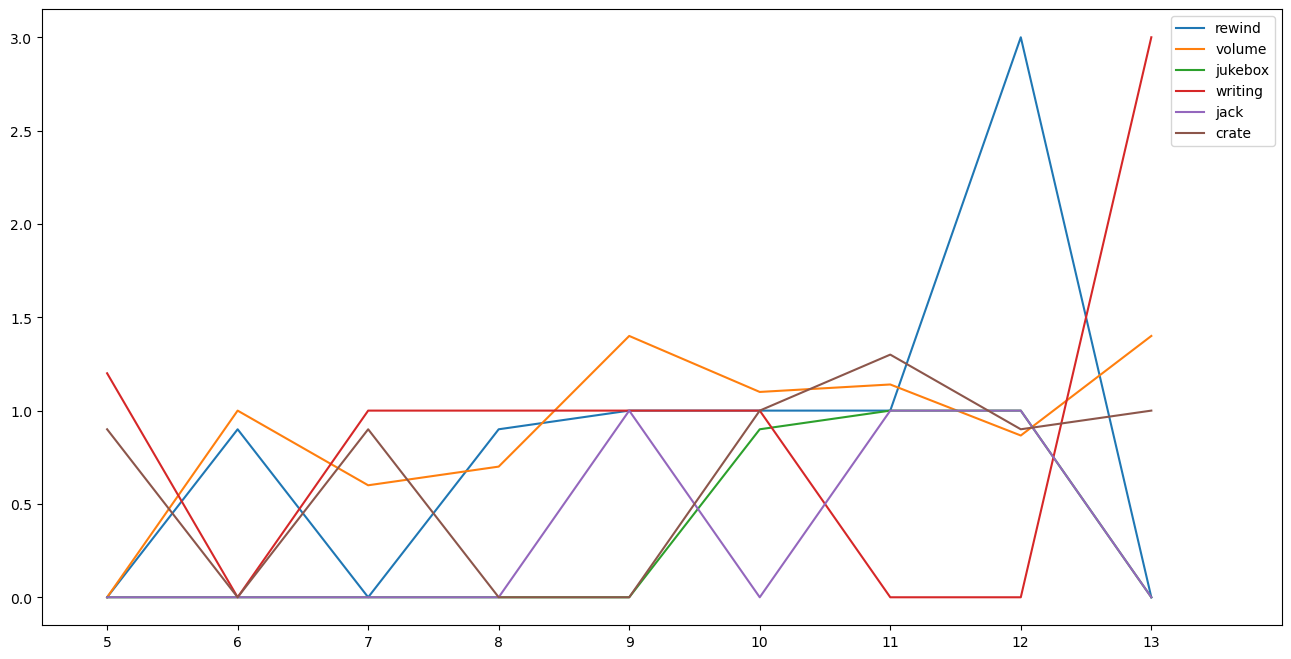

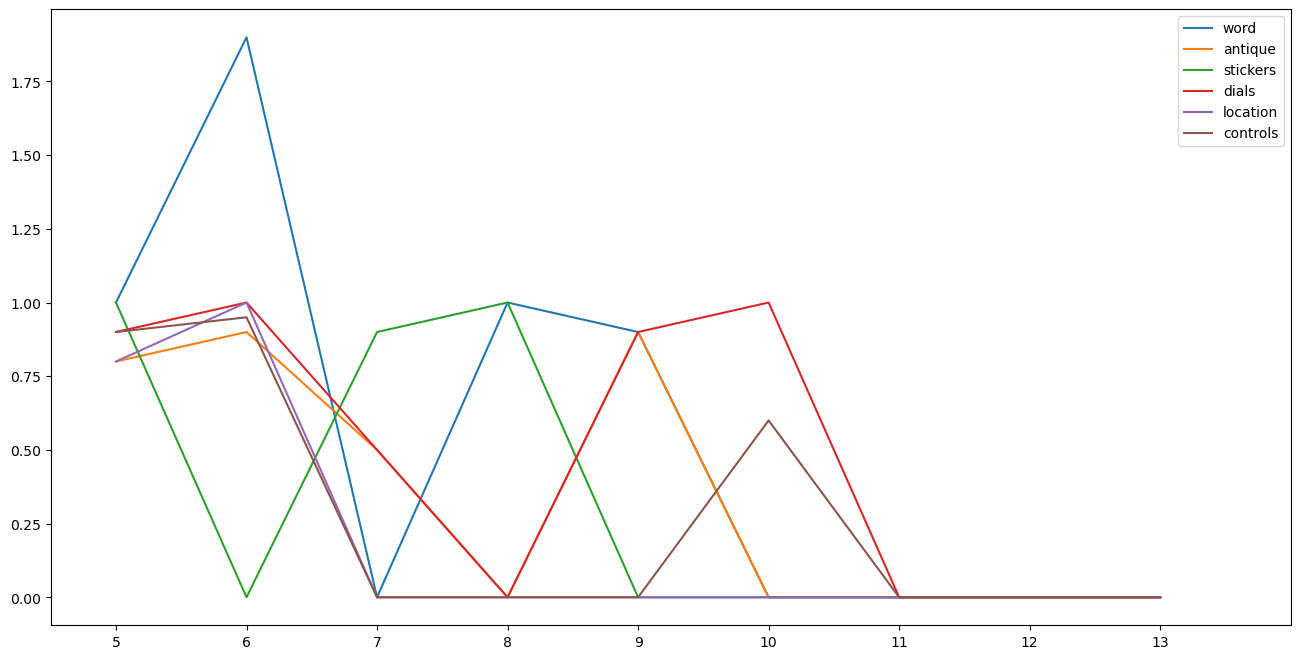

In [5]:
make_label_plot(df_char[0], df_cluster[0])

In [6]:
def plot_unique_chars(dfs_char, dfs_cluster):
    x = np.linspace(0,8,9)
    ys = []
    for i in range(0, 10):
        df_char = dfs_char[i]
        df_cluster = dfs_cluster[i]
        y = []
        for layer in range(0, 9):
            unique_for_layer = df_char[df_char.cluster_id.isin(df_cluster[df_cluster.layer == layer]['cluster_id'])]['characteristic'].drop_duplicates().shape[0]
            y.append(unique_for_layer)
        ys.append(y)
    ys = np.sum(ys, axis=0)
    plt.plot(x, ys)
    plt.show()

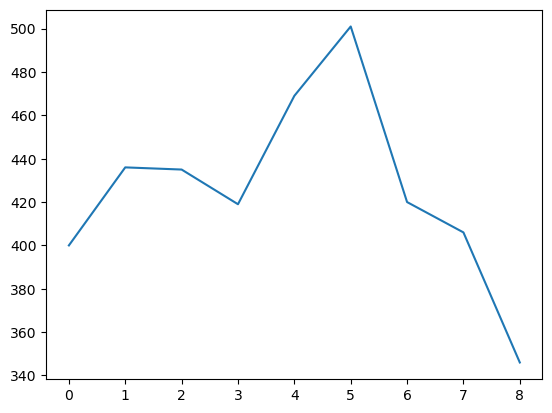

In [7]:
plot_unique_chars(df_char, df_cluster)

In [8]:
def boxplot_percentiles(original_df):
    percentile_list = original_df.groupby('guess_id').first().groupby('layer').agg({'percentile':lambda x: x.to_list()})['percentile'].to_list()

    plt.figure(figsize=(16, 6))
    plt.violinplot(percentile_list, positions=np.linspace(5,13,9, dtype=int), points=6)
    plt.xticks(np.linspace(5,13,9,dtype=int))
    plt.xlabel('layer')
    plt.ylabel('hints used')
    plt.show()

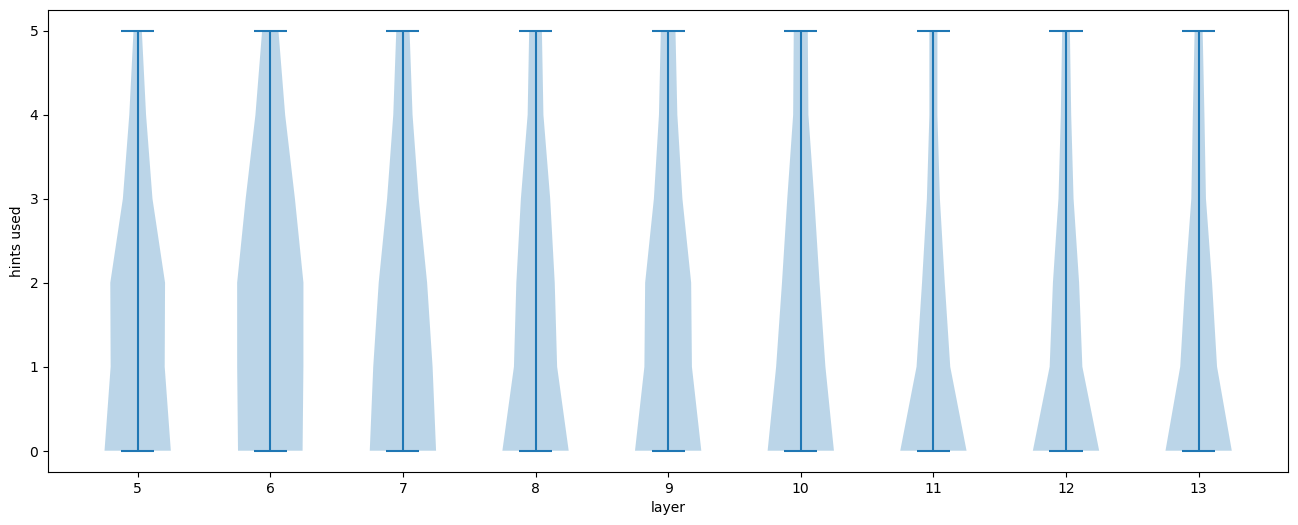

In [9]:
boxplot_percentiles(original_df)

In [10]:
for i in range(len(df_char)):
    df_char[i]['label'] = i

df_char = pd.concat(df_char).reset_index()

In [11]:
for i in range(len(df_cluster)):
    df_cluster[i]['label'] = i

df_cluster = pd.concat(df_cluster).reset_index()

In [12]:
for i in range(len(df_merged)):
    df_merged[i]['label'] = i
    

df_merged = pd.concat(df_merged).reset_index()

In [13]:
listrow = []
for index, row in df_char.iterrows():
    row['layer'] = df_cluster[df_cluster.cluster_id == row['cluster_id']]['layer'].to_list()[0]
    listrow.append(row)
df_char = pd.DataFrame(listrow)

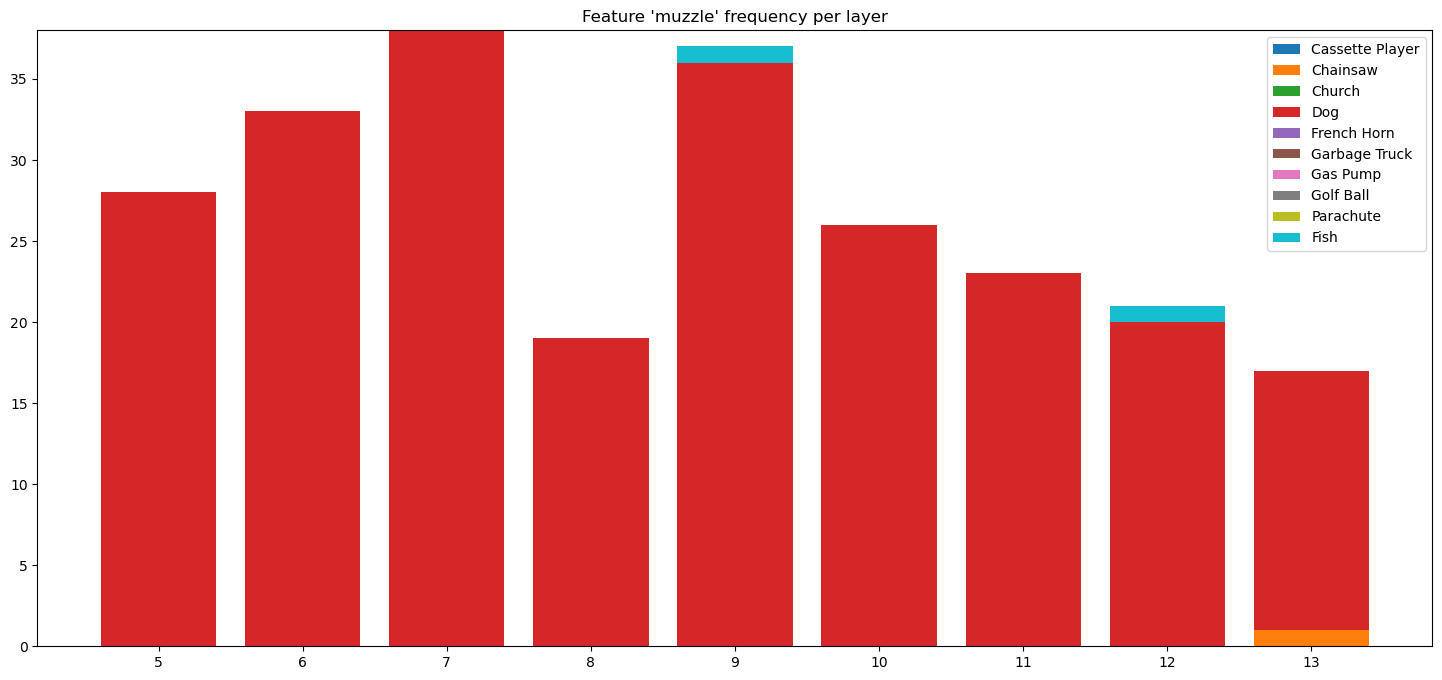

In [14]:
char = 'muzzle'
plt.figure(figsize=(18, 8))
x = np.linspace(5,13,9)
bottom = np.zeros(9)
for label in df_char['label'].drop_duplicates().to_list():
    y_1 = df_char[df_char.characteristic == char]
    y = y_1[y_1.label == label].groupby('layer').sum()['frequency'].to_dict()
    for i in range(0, 9):
        if i not in y.keys(): y.update({i:0})
    y = dict(sorted(y.items()))
    plt.title('Feature \''+char + '\' frequency per layer')
    plt.bar(x, y.values(), bottom=bottom, label=LABELS[label])
    bottom = np.add(bottom, list(y.values()))
plt.legend()
plt.xticks(x)
plt.show()

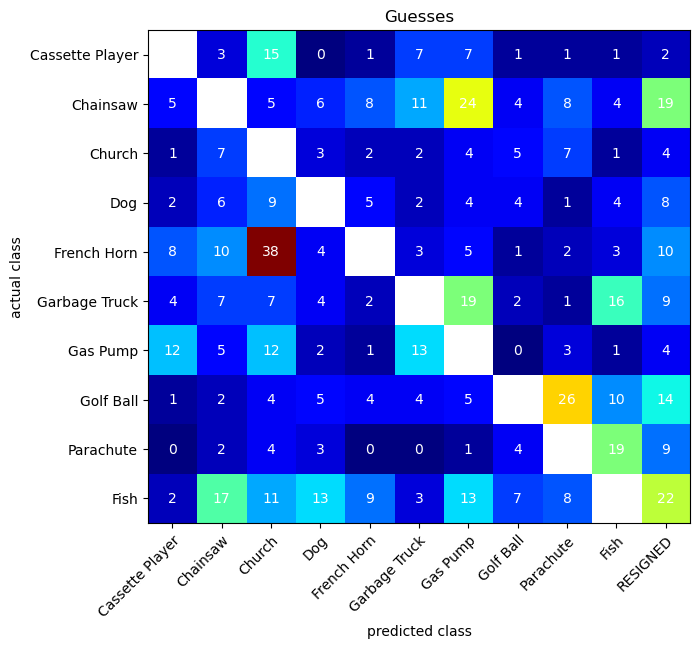

In [15]:
guess_df = original_df.groupby('guess_id').agg({'guessed_label_id':lambda x: LABELS[x.to_list()[0]-1], 'label_en':lambda x: x.to_list()[0]})
predicted = guess_df['guessed_label_id'].to_list()
actual = guess_df['label_en'].to_list()

guess_heatmap = np.zeros(shape=(10,11))
for i in range(len(predicted)):
    guess_heatmap[LABELS.index(actual[i])][LABELS.index(predicted[i])]+=1
guess_heatmap[:,10] = np.array(df_cluster[df_cluster.resign_count > 0].groupby('label').count()['resign_count'].to_list())

for i in range(10):
    guess_heatmap[i,i] = np.nan

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
im = ax.imshow(guess_heatmap, cmap='jet')

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(LABELS)), labels=LABELS)
ax.set_xticks(np.arange(len(LABELS)+1), labels=LABELS+['RESIGNED'])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(LABELS)):
    for j in range(len(LABELS)+1):
        if i!=j:
            text = plt.text(j, i, int(guess_heatmap[i, j]),
                           ha="center", va="center", color="w")

ax.set_title("Guesses")
ax.set_ylabel('actual class')
ax.set_xlabel('predicted class')
plt.show()

In [16]:
def plots_weight_and_percentiles(original_df:pd.DataFrame):
    cluster_list = original_df.groupby('guess_id').first().groupby('percentile').agg({'cluster_id':lambda x: x.to_list()})['cluster_id'].to_list()

    def get_weight(id):
        return df_cluster[df_cluster.cluster_id == id]['weight'].to_list()[0]

    vget_weight = np.vectorize(get_weight)
    weights_list = []
    for cluster_group in cluster_list: weights_list.append(vget_weight(cluster_group))
    weights_list.reverse()
    plt.figure(figsize=(18, 6))
    plt.boxplot(weights_list, positions=np.linspace(5,0,6, dtype=int), vert=False)
    plt.xlabel('weight')
    plt.ylabel('hints used')
    plt.xticks([0,20,40,60,80,100])
    plt.show()
    plt.figure(figsize=(6, 6))
    plt.violinplot(weights_list, positions=np.linspace(0,5,6, dtype=int))
    plt.show()

    means = []
    medians = []
    errors = []
    for array in weights_list:
        means.append(np.mean(array))
        medians.append(np.median(array))
        errors.append((np.max(array)-np.min(array))/2)
    
    plt.figure(figsize=(16, 6))
    plt.plot(np.linspace(0,5,6), means, label='mean', c='r')
    plt.plot(np.linspace(0,5,6), medians, label='median', c='b')
    plt.legend()
    plt.show()

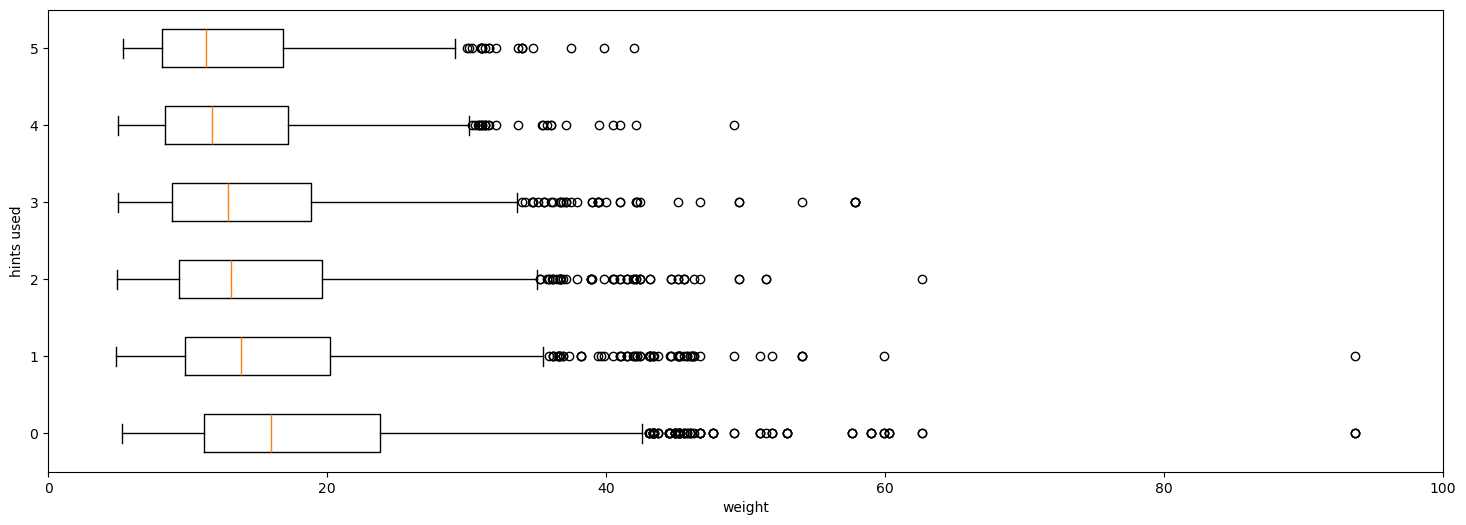

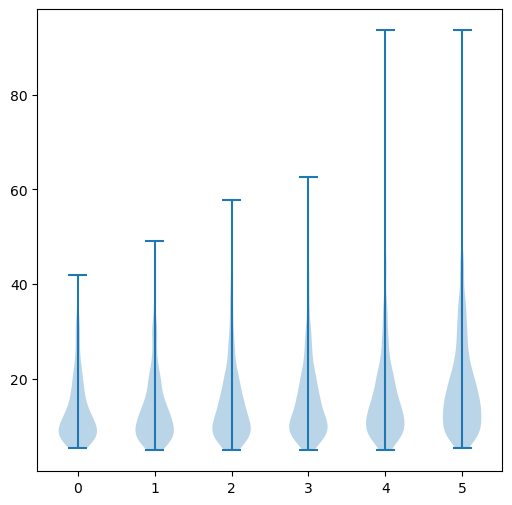

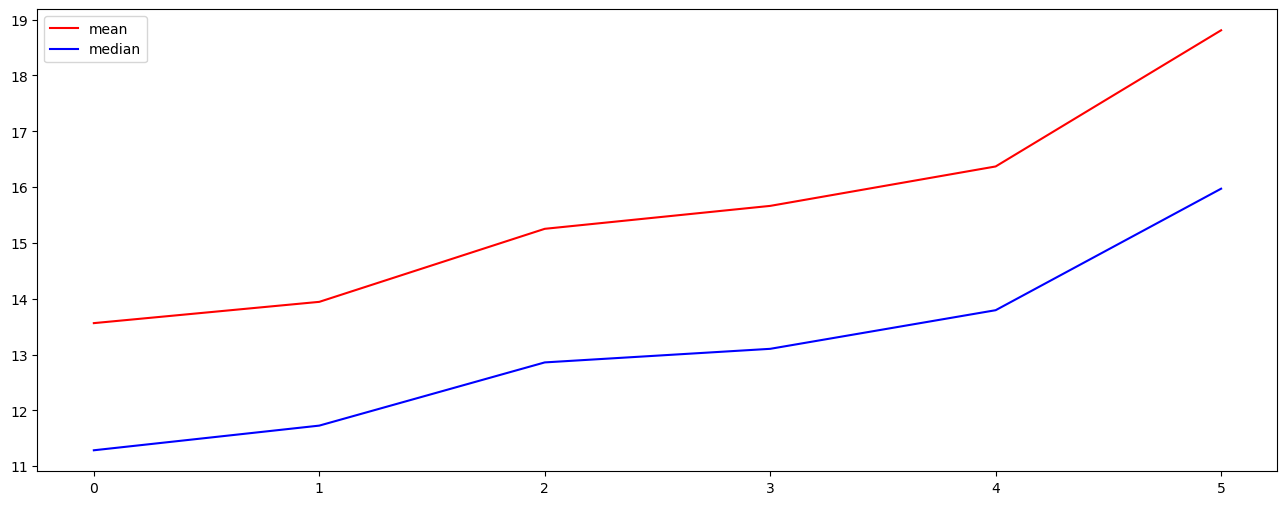

In [17]:
plots_weight_and_percentiles(original_df)

In [22]:
listrow = []
for index, row in df_merged.iterrows():
    cluster_group = row['cluster_id']
    data = df_char[df_char.cluster_id.isin(cluster_group)]
    data_dict = dict()
    total_weight = sum(df_cluster[df_cluster.cluster_id.isin(cluster_group)]['weight'].values)
    for c in data['characteristic'].drop_duplicates().to_list():
        c_data = data[data.characteristic == c]
        char_score = 0
        for cluster in c_data['cluster_id'].to_list():
            char_score += df_cluster[df_cluster.cluster_id == cluster]['weight'].values[0]*c_data[c_data.cluster_id == cluster]['score'].values[0]
        #data_dict.update({c:data[data.characteristic == c]['score'].sum()})
        data_dict.update({c: char_score/total_weight})
    best_chars = [key for key, value in data_dict.items() if value == max(data_dict.values())]
    best_scores = [value for key, value in data_dict.items() if value == max(data_dict.values())]
    if len(best_chars) == 0: continue
    row['best_characteristics'] = best_chars
    row['best_score'] = np.round(best_scores,2)[0]
    listrow.append(row)
df_merged = pd.DataFrame(listrow)

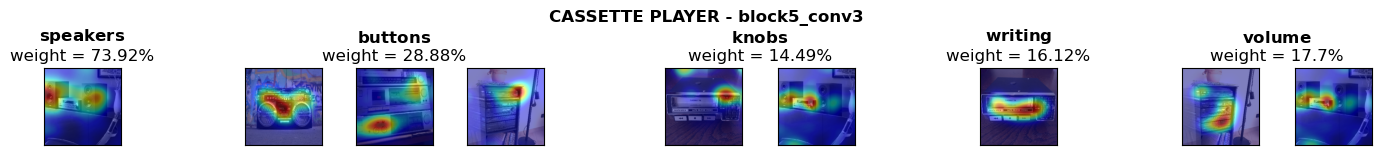

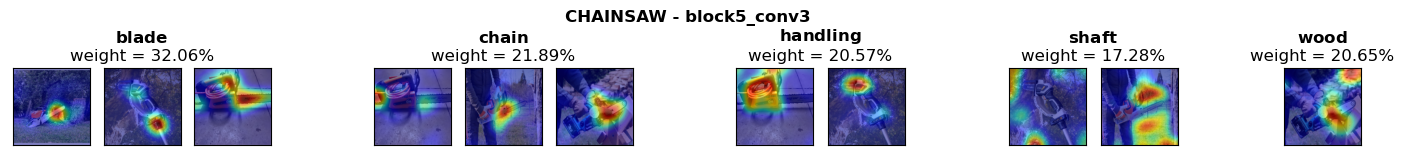

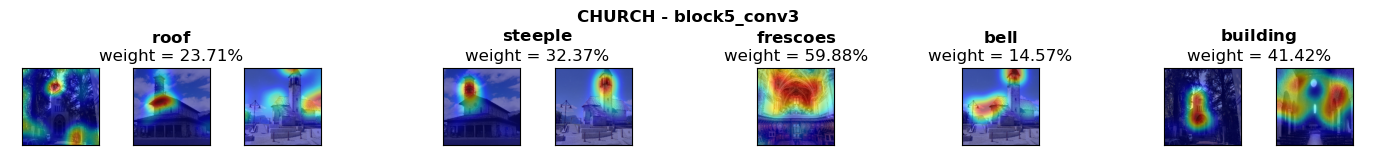

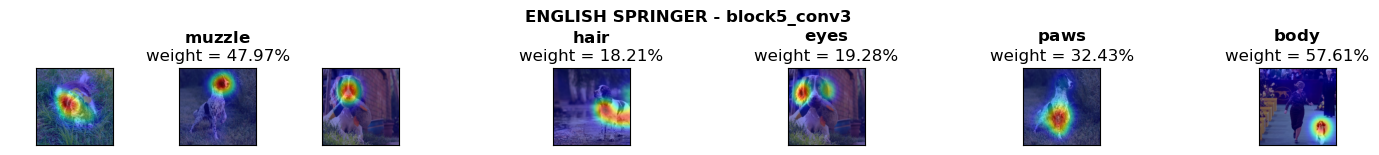

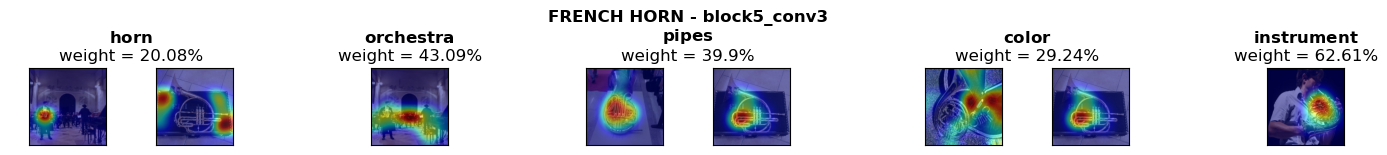

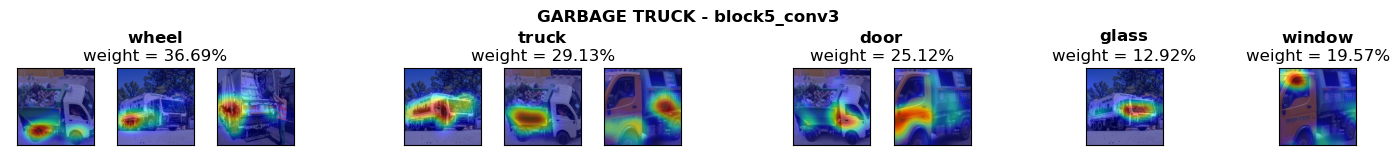

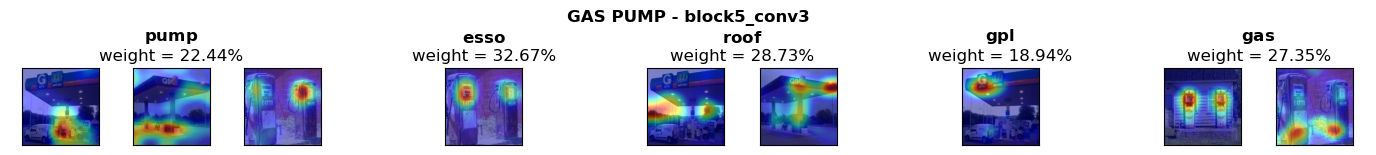

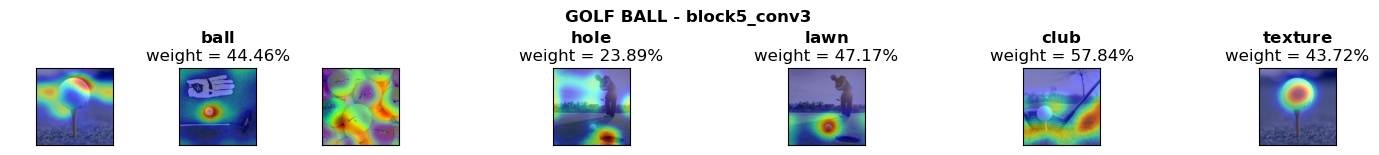

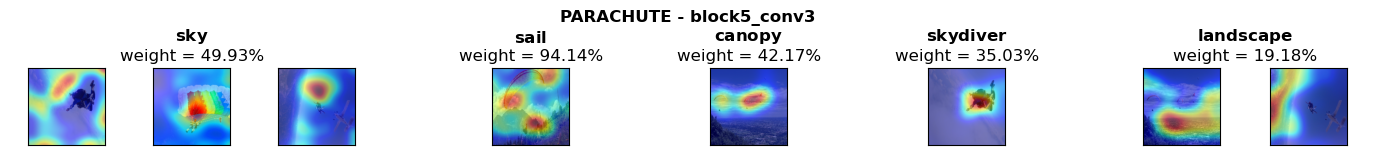

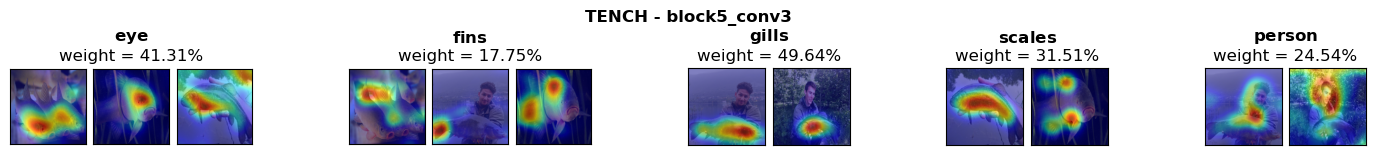

In [23]:
TRUE_LABELS = ['Cassette Player', 'Chainsaw', 'Church', 'English Springer', 'French Horn', 'Garbage Truck', 'Gas Pump', 'Golf Ball', 'Parachute', 'Tench']
LAYER = [8]
N_COLS = 5
N_IMAGES = 3

val = LAYER[0]
list_chars, list_weights = [], []
list_best_scores = [[]]*10
for i in range(0,10):
    best_dict = dict()
    for index, row in df_merged.explode('best_characteristics')[df_merged.label == i][df_merged.layer.isin(LAYER)].sort_values('best_characteristics').iterrows():
        df_best = df_char[df_char.cluster_id.isin(row['cluster_id'])][df_char.characteristic.isin([row['best_characteristics']])].groupby('characteristic')['score'].sum().to_dict()
        for key, value in df_best.items():
            if key not in best_dict.keys():
                best_dict.update({key:value})
            else:
                best_dict[key] += value
    
    c = list(dict(sorted(best_dict.items(), key=lambda x: x[1], reverse=True)).keys())[:N_COLS]
    list_best_scores[i]=list(dict(sorted(best_dict.items(), key=lambda x: x[1], reverse=True)).values())
    temp = df_merged[df_merged.label == i][df_merged.layer.isin(LAYER)].explode('best_characteristics')
    temp_w = temp[temp.best_characteristics.isin(c)].groupby('best_characteristics')['weight'].mean().to_dict()
    w = dict()
    for key in c:
        w.update({key:temp_w[key]})
    w = list(w.values())
    list_chars.append(c)
    list_weights.append(w)

#gs = gridspec.GridSpec(10, 1, height_ratios=[1 for i in range(10)], hspace=0.7)
for i in range(10):
    wratios = []
    for j in range(N_COLS):
        if j >= len(list_chars[i]): continue
        char_str = list_chars[i][j]
        char_weight = list_weights[i][j]
        temp = df_merged[df_merged.label == i]
        temp2 = temp[temp.layer.isin(LAYER)].explode('best_characteristics')
        temp3 = temp2[temp2.best_characteristics == char_str].sort_values('best_score', ascending=False)
        listrow = []
        for image_id in temp3['image_id'].drop_duplicates():
            temp4 = temp3[temp3.image_id == image_id]
            r = temp4[temp4.best_score == temp4['best_score'].max()]
            listrow.append(r.iloc[0])
        top_chars = pd.DataFrame(listrow)[:N_IMAGES]
        wratios.append(len(top_chars))


    fig = plt.figure(figsize=(N_COLS*3.5,1))
    gs_row = gridspec.GridSpec(1, N_COLS, wspace=.5, width_ratios=wratios)
    grid_row = fig.add_subplot(gs_row[:])
    grid_row.axis('off')
    grid_row.set_xticks([])
    grid_row.set_yticks([])
    grid_row.set_title(TRUE_LABELS[i].upper()+ ' - block'+str(int(val/3)+3)+'_conv'+str(val%3 + 1), y=1.5, fontweight='bold')

    for j in range(N_COLS):
        if j >= len(list_chars[i]): continue
        char_str = list_chars[i][j]
        char_weight = list_weights[i][j]
        temp = df_merged[df_merged.label == i]
        temp2 = temp[temp.layer.isin(LAYER)].explode('best_characteristics')
        temp3 = temp2[temp2.best_characteristics == char_str].sort_values('best_score', ascending=False)
        listrow = []
        for image_id in temp3['image_id'].drop_duplicates():
            temp4 = temp3[temp3.image_id == image_id]
            r = temp4[temp4.best_score == temp4['best_score'].max()]
            listrow.append(r.iloc[0])
        top_chars = pd.DataFrame(listrow)[:N_IMAGES]
        #top_chars = temp3[temp3['best_score'] == temp3.groupby(['image_id','best_characteristics'])['best_score'].transform(max)][:N_IMAGES]
        sub_gs = gridspec.GridSpecFromSubplotSpec(1, top_chars.shape[0], subplot_spec=gs_row[j], wspace=.1)
        cell = fig.add_subplot(gs_row[j])
        cell.axis('off')
        cell.set_xticks([])
        cell.set_yticks([])
        cell.set_title('$\\bf{'+char_str+'}$\nweight = '+str(np.round(char_weight,2))+ '%')

        cnt = 0
        for index, row in top_chars.iterrows():
            original_image = get_image(row['image'], 'images/')
            heatmaps = heatmap_df[heatmap_df.id.isin(row['cluster_id'])].sort_values(by='id')['heatmap'].to_list()
            heatmaps = parse_heatmaps(heatmaps)
            weights = df_cluster[df_cluster.cluster_id.isin(row['cluster_id'])].sort_values(by='cluster_id')['weight'].to_list()
            heatmap = compute_average_heatmap(heatmaps, weights)
            overlay_image = compute_overlay(original_image, heatmap, 512, 512)
            ax = fig.add_subplot(sub_gs[0, cnt])
            ax.imshow(overlay_image)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.set_title(str(np.round(row['weight'],2))+'%')
            cnt+=1
    
    fpath = 'global/'+ 'block'+str(int(val/3)+3)+'_conv'+str(val%3 + 1)+'/'+TRUE_LABELS[i]
    plt.savefig(fpath, bbox_inches='tight')
    #plt.show()